# Day length, sunrise, and sunset calculation for Earth system models

In [1]:
import datetime
import numpy as np


coords = []
doy = int()

# The sunrise_sunset() algorithm was written for degrees, not radians
sine = lambda x: np.sin(np.deg2rad(x))
cosine = lambda x: np.cos(np.deg2rad(x))
tan = lambda x: np.tan(np.deg2rad(x))
arcsin = lambda x: np.rad2deg(np.arcsin(x))
arccos = lambda x: np.rad2deg(np.arccos(x))
arctan = lambda x: np.rad2deg(np.arctan(x))

def sunrise_sunset(coords, dt, zenith = -0.83):
    '''
    Returns the hour of sunrise and sunset for a given date. Hours are on the
    closed interval [0, 23] because Python starts counting at zero; i.e., if
    we want to index an array of hourly data, 23 is the last hour of the day.
    Recommended solar zenith angles for sunrise and sunset are -6 degrees for
    civil sunrise/ sunset; -0.5 degrees for "official" sunrise/sunset; and
    -0.83 degrees to account for the effects of refraction. A zenith angle of
    -0.5 degrees produces results closest to those of pyephem's
    Observer.next_rising() and Observer.next_setting(). This calculation does
    not include corrections for elevation or nutation nor does it explicitly
    correct for atmospheric refraction. Source:
        U.S. Naval Observatory. "Almanac for Computers." 1990.

    Parameters
    ----------
    coords : list or tuple
        The (longitude, latitude) coordinates of interest; coordinates can
        be scalars or arrays (for times at multiple locations on same date)
    dt : datetime.date
        The date on which sunrise and sunset times are desired
    zenith : float
        The sun zenith angle to use in calculation, i.e., the angle of the
        sun with respect to its highest point in the sky (90 is solar noon)
        (Default: -0.83)

    Returns
    -------
    tuple
        2-element tuple of (sunrise hour, sunset hour)
    '''
    lat, lng = coords
    assert -90 <= lat <= 90, 'Latitude error'
    assert -180 <= lng <= 180, 'Longitude error'
    doy = int(dt.strftime('%j'))
    # Calculate longitude hour (Earth turns 15 degrees longitude per hour)
    lng_hour = lng / 15.0
    # Appoximate transit time (longitudinal average)
    tmean = doy + ((12 - lng_hour) / 24)
    # Solar mean anomaly at rising, setting time
    anomaly = (0.98560028 * tmean) - 3.289
    # Calculate sun's true longitude by calculating the true anomaly
    #   (anomaly + equation of the center), then add (180 + omega)
    #   where omega = 102.634 is the longitude of the perihelion
    lng_sun = (anomaly + (1.916 * sine(anomaly)) +\
        (0.02 * sine(2 * anomaly)) + 282.634) % 360
    # Sun's right ascension (by 0.91747 = cosine of Earth's obliquity)
    ra = arctan(0.91747 * tan(lng_sun)) % 360
    # Adjust RA to be in the same quadrant as the sun's true longitude, then
    #   convert to hours by dividing by 15 degrees
    ra += np.subtract(
        np.floor(lng_sun / 90) * 90, np.floor(ra / 90) * 90)
    ra_hours = ra / 15
    # Sun's declination's (using 0.39782 = sine of Earth's obliquity)
    #   retained as sine and cosine
    dec_sin = 0.39782 * sine(lng_sun)
    dec_cos = cosine(arcsin(dec_sin))
    # Cosine of the sun's local hour angle
    hour_angle_cos = (
        sine(zenith) - (dec_sin * sine(lat))) / (dec_cos * cosine(lat))
    # Correct for polar summer or winter, i.e., when the sun is always
    #   above or below the horizon
    
    # Air Mass
    AM = 1/(hour_angle_cos + 0.50572 * ((96.07995 - hour_angle)^(-1.6364)))
    
    if hour_angle_cos > 1 or hour_angle_cos < -1:
        if hour_angle_cos > 1:
            return (0, 0) # Sun is always down
        elif hour_angle_cos < -1:
            return (0, 23) # Sun is always up
    hour_angle = arccos(hour_angle_cos)
    # Local mean time of rising or setting (converting hour angle to hours)
    hour_rise = ((360 - hour_angle) / 15) + ra_hours -\
    (0.06571 * (tmean - 0.25)) - 6.622
    hour_sets = (hour_angle / 15) + ra_hours -\
    (0.06571 * (tmean + 0.25)) - 6.622
    # Round to nearest hour, convert to UTC
    return (
        np.floor((hour_rise - lng_hour) % 24),
        np.floor((hour_sets - lng_hour) % 24))

In [2]:
pip install ephem

Note: you may need to restart the kernel to use updated packages.


In [3]:
import ephem

SUN = ephem.Sun() # Module-level constant

obs = ephem.Observer()
# Positions in degrees are expected to be str type
obs.lat, obs.long = map(str, coords)
obs.date = dt.strftime('%Y-%m-%d')
obs.pressure = 0 # Do not calculate refraction
try:
    rising = obs.next_rising(SUN).datetime().hour
except (ephem.AlwaysUpError, ephem.NeverUpError):
    rising = -1
try:
    setting = obs.next_setting(SUN).datetime().hour
except ephem.AlwaysUpError:
    setting = 23
except ephem.NeverUpError:
    setting = -1
return (rising, setting)

# input query for LAT, LON?


ValueError: not enough values to unpack (expected 2, got 0)

In [4]:
pip install astral

Note: you may need to restart the kernel to use updated packages.


In [5]:
from astral import LocationInfo
from astral.sun import sun

lat, lng = coords
loc = LocationInfo()
loc.latitude = lat
loc.longitude = lng
try:
    s = sun(loc.observer, date = dt)
except ValueError as err:
    if lat > 60 and dt.month in (4, 5, 6, 7, 8, 9):
        return (0, 23) # Sun always up above Arctic Circle
    if lat < -60 and dt.month in (1, 2, 3, 10, 11, 12):
        return (0, 23) # Sun always up below Antarctic Circle
    return (-1, -1) # Sun always down
return (s['sunrise'].hour, s['sunset'].hour)

ValueError: not enough values to unpack (expected 2, got 0)

# Radiation

In [6]:
pip install solarpy

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install pysolar

Note: you may need to restart the kernel to use updated packages.


In [24]:
import matplotlib.pyplot as plt

from datetime import datetime, timedelta, timezone
from pysolar import radiation, solar

In [25]:
lat = 36.18
lon = -94.54

In [26]:
start = datetime(2023, 5, 27, tzinfo=timezone.utc)

In [27]:
dates = [start + timedelta(minutes=i*15) for i in range(24*4)]

In [28]:
altitude = [solar.get_altitude(lat, lon, d) for d in dates]

In [29]:
azimuth = [solar.get_azimuth(lat, lon, d) for d in dates]

Text(0, 0.5, 'azimuth (deg)')

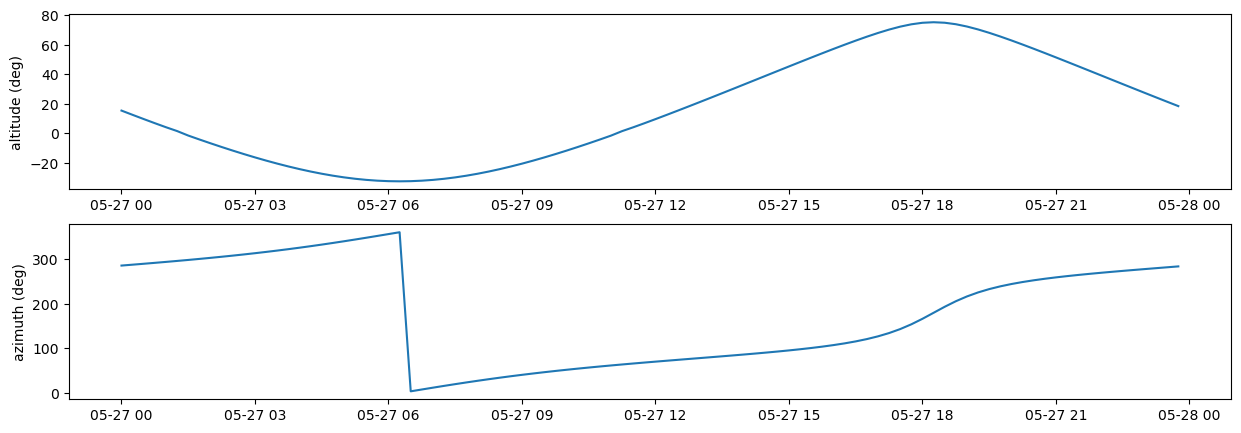

In [30]:
fig, axes = plt.subplots(nrows=2, figsize=(15,5))
axes[0].plot(dates, altitude)
axes[1].plot(dates, azimuth)
axes[0].set_ylabel('altitude (deg)')
axes[1].set_ylabel('azimuth (deg)')

In [31]:
rad = [radiation.get_radiation_direct(d, alt) for d, alt in zip(dates, altitude)]

Text(0, 0.5, 'radiation [w/m^2]')

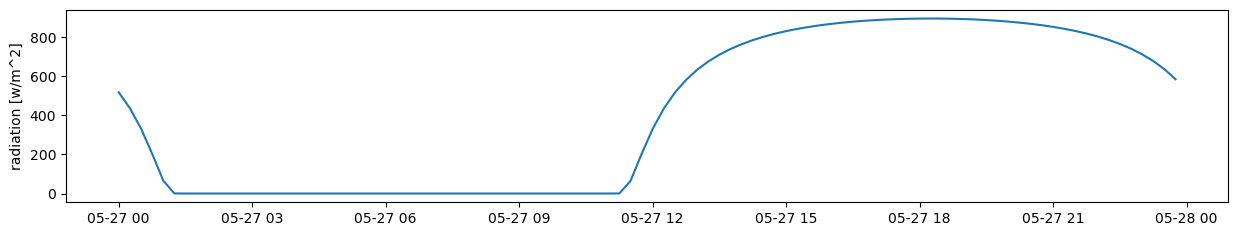

In [32]:
plt.figure(figsize=(15, 2.5))
plt.plot(dates, rad)
plt.ylabel('radiation [w/m^2]')

# https://pypi.org/project/solarpy/

In [17]:
# Solar irradiance on the southern hemisphere on October 17, at sea-level 13.01UTC (plane pointing upwards)?

# https://pypi.org/project/solarpy/
import numpy as np
from solarpy import irradiance_on_plane
from datetime import datetime

vnorm = np.array([0, 0, -1])  # plane pointing zenith
h = 0  # sea-level
date = datetime(2019, 10, 17, 13, 1)  # year, month, day, hour, minute
lat = -23.5  # southern hemisphere

irradiance_on_plane(vnorm, h, date, lat)

915.6972312298068

In [18]:
# Power output (in W) of a solar panel with the following characteristics:
# surface of 2.1 sqm
# efficiency of 0.2
# pointing upwards
# in NYC
# on December 25, at 16.15
from numpy import array
from solarpy import solar_panel
from datetime import datetime

panel = solar_panel(2.1, 0.2, id_name='NYC_xmas')  # surface, efficiency and name
panel.set_orientation(array([0, 0, -1]))  # upwards
panel.set_position(40.73, -73.93, 0)  # NYC latitude, longitude, altitude
panel.set_datetime(datetime(2019, 12, 25, 16, 15))  # Christmas Day!
panel.power()

0.17671118579916487

In [19]:
# Solar declination on August 5?
from solarpy import declination
from datetime import datetime

date = datetime(2019, 8, 5)  # August 5

declination(date)

0.3000523452280928

In [20]:
# https://pypi.org/project/solarpy/
# https://levelup.gitconnected.com/python-sun-position-for-solar-energy-and-research-7a4ead801777
# https://notebook.community/uvchik/pvlib-python/docs/tutorials/irradiance
# https://earthscience.stackexchange.com/questions/14491/how-to-calculate-the-solar-radiation-at-any-place-any-time
# https://www.youtube.com/watch?v=EHWC_7hRWe4

# https://levelup.gitconnected.com/python-sun-position-for-solar-energy-and-research-7a4ead801777

In [21]:
# sunpos.py
import math
def sunpos(when, location, refraction):
# Extract the passed data
    year, month, day, hour, minute, second, timezone = when
    latitude, longitude = location
# Math typing shortcuts
    rad, deg = math.radians, math.degrees
    sin, cos, tan = math.sin, math.cos, math.tan
    asin, atan2 = math.asin, math.atan2
# Convert latitude and longitude to radians
    rlat = rad(latitude)
    rlon = rad(longitude)
# Decimal hour of the day at Greenwich
    greenwichtime = hour - timezone + minute / 60 + second / 3600
# Days from J2000, accurate from 1901 to 2099
    daynum = (
        367 * year
        - 7 * (year + (month + 9) // 12) // 4
        + 275 * month // 9
        + day
        - 730531.5
        + greenwichtime / 24
    )
# Mean longitude of the sun
    mean_long = daynum * 0.01720279239 + 4.894967873
# Mean anomaly of the Sun
    mean_anom = daynum * 0.01720197034 + 6.240040768
# Ecliptic longitude of the sun
    eclip_long = (
        mean_long
        + 0.03342305518 * sin(mean_anom)
        + 0.0003490658504 * sin(2 * mean_anom)
    )
# Obliquity of the ecliptic
    obliquity = 0.4090877234 - 0.000000006981317008 * daynum
# Right ascension of the sun
    rasc = atan2(cos(obliquity) * sin(eclip_long), cos(eclip_long))
# Declination of the sun
    decl = asin(sin(obliquity) * sin(eclip_long))
# Local sidereal time
    sidereal = 4.894961213 + 6.300388099 * daynum + rlon
# Hour angle of the sun
    hour_ang = sidereal - rasc
# Local elevation of the sun
    elevation = asin(sin(decl) * sin(rlat) + cos(decl) * cos(rlat) * cos(hour_ang))
# Local azimuth of the sun
    azimuth = atan2(
        -cos(decl) * cos(rlat) * sin(hour_ang),
        sin(decl) - sin(rlat) * sin(elevation),
    )
# Convert azimuth and elevation to degrees
    azimuth = into_range(deg(azimuth), 0, 360)
    elevation = into_range(deg(elevation), -180, 180)
# Refraction correction (optional)
    if refraction:
        targ = rad((elevation + (10.3 / (elevation + 5.11))))
        elevation += (1.02 / tan(targ)) / 60
# Return azimuth and elevation in degrees
    return (round(azimuth, 2), round(elevation, 2))
def into_range(x, range_min, range_max):
    shiftedx = x - range_min
    delta = range_max - range_min
    return (((shiftedx % delta) + delta) % delta) + range_min
if __name__ == "__main__":
# Close Encounters latitude, longitude
    location = (40.602778, -104.741667)
# Fourth of July, 2022 at 11:20 am MDT (-6 hours)
    when = (2022, 7, 4, 11, 20, 0, -6)
# Get the Sun's apparent location in the sky
    azimuth, elevation = sunpos(when, location, True)
# Output the results
    print("\nWhen: ", when)
    print("Where: ", location)
    print("Azimuth: ", azimuth)
    print("Elevation: ", elevation)
# When:  (2022, 7, 4, 11, 20, 0, -6)
# Where:  (40.602778, -104.741667)
# Azimuth:  121.38
# Elevation:  61.91


When:  (2022, 7, 4, 11, 20, 0, -6)
Where:  (40.602778, -104.741667)
Azimuth:  121.38
Elevation:  61.91


# https://earthscience.stackexchange.com/questions/14491/how-to-calculate-the-solar-radiation-at-any-place-any-time

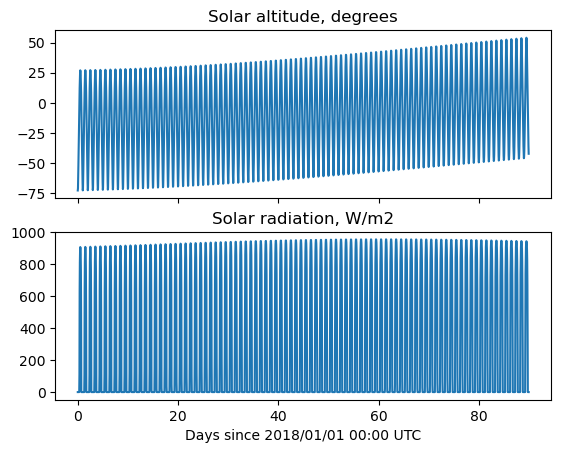

In [22]:
import datetime
import matplotlib.pyplot as plt
import pysolar
lat, lon = 39.9075, 116.39723  # Beijing, China
timezone = datetime.timezone(datetime.timedelta(hours=8))  # 0800 UTC
start = datetime.datetime(2018,1,1,tzinfo=timezone)  # 1 Jan 2018

# Calculate radiation every hour for 90 days
nhr = 24*90
dates, altitudes_deg, radiations = list(), list(), list()
for ihr in range(nhr):
    date = start + datetime.timedelta(hours=ihr)
    altitude_deg = pysolar.solar.get_altitude(lat,lon,date)
    if altitude_deg <= 0:
        radiation = 0.
    else:
        radiation = pysolar.radiation.get_radiation_direct(date,altitude_deg)
    dates.append(date)
    altitudes_deg.append(altitude_deg)
    radiations.append(radiation)

days = [ihr/24 for ihr in range(nhr)]
fig, axs = plt.subplots(nrows=2,ncols=1,sharex=True)
axs[0].plot(days,altitudes_deg)
axs[0].set_title('Solar altitude, degrees')
axs[1].plot(days,radiations)
axs[1].set_title('Solar radiation, W/m2')
axs[1].set_xlabel('Days since ' + start.strftime('%Y/%m/%d %H:%M UTC'))
plt.show()

# More advanced options

In [ ]:
# https://notebook.community/uvchik/pvlib-python/docs/tutorials/irradiance